In [2]:
import duckdb

# Directly query CSV without converting to DataFrame first
con = duckdb.connect()

In [4]:
# Create connection
con = duckdb.connect()

# Check first CSV
query1 = "SELECT * FROM 'clips.csv' LIMIT 3"
df1 = con.execute(query1).df()
print(df1)

# Check second CSV
query2 = "SELECT * FROM 'downloaded_clips.csv' LIMIT 3"
df2 = con.execute(query2).df()
print(df2)

# Check third CSV
query3 = "SELECT * FROM 'gamesession.csv' LIMIT 3"
df3 = con.execute(query3).df()
print(df3)

# Check fourth CSV
query4 = "SELECT * FROM 'premium.csv' LIMIT 3"
df4 = con.execute(query4).df()
print(df4)

# Check fifth CSV
query5 = "SELECT * FROM 'shared_clips.csv' LIMIT 3"
df5 = con.execute(query5).df()
print(df5)

             id  user_id  gamesession_Id  clip_type_id  duration  \
0  134469944895  3095890     103039886.0             5        60   
1  134470123490  3095890     103039886.0             5        60   
2  134470573860  2844164     100738061.0             2        10   

     event_name          game_name          created_at             join_at  
0  High Comment        Other Games 2023-06-01 12:00:21 2023-01-29 15:16:25  
1  High Comment        Other Games 2023-06-01 12:00:45 2023-01-29 15:16:25  
2          None  World of Warcraft 2023-06-01 12:01:47 2023-03-10 23:27:14  
          id  user_Id       clip_id  gamesession_Id          game_name  \
0  556784158  2844164  134463515475     100738061.0  World of Warcraft   
1  556784256  2844164  134464540455     100738061.0  World of Warcraft   
2  556784354  2844164  134466310875     100738061.0  World of Warcraft   

  event_name          created_at             join_at  
0       None 2023-06-01 12:20:56 2023-03-10 23:27:14  
1       None

# Segmentation of Eklipse Business Metrics

## 1. User Engagement & Activity:

### - Monthly Active Users (MAU):

            Tracks the total unique users engaging with any part of the platform. In this context, a user is considered "active" if 
            they perform any of the following actions within a given month:

            - Submitting a gamesession (from the gamesession table)

            - Creating a clip (from the clips table)

            - Downloading a clip (from the downloaded_clips table)

            - Sharing a clip (from the shared_clips table)

In [6]:
query1 = '''
SELECT
    DATE_TRUNC('month', activity.activity_date) AS month,
    COUNT(DISTINCT activity.user_id) AS monthly_active_users
FROM (
    SELECT
        user_id,
        submited_date AS activity_date
    FROM 'gamesession.csv'
    WHERE submited_date IS NOT NULL

    UNION ALL

    SELECT
        user_id,
        created_at AS activity_date
    FROM 'clips.csv'
    WHERE created_at IS NOT NULL

    UNION ALL

    SELECT
        user_id,
        created_at AS activity_date
    FROM 'downloaded_clips.csv'
    WHERE created_at IS NOT NULL

    UNION ALL

    SELECT
        user_id,
        created_at AS activity_date
    FROM 'shared_clips.csv'
    WHERE created_at IS NOT NULL
) AS activity
GROUP BY
    month
ORDER BY
    month;
'''
result1 = con.execute(query1).df()
display(result1)

,month,monthly_active_users
0,2023-06-01,1103
1,2023-07-01,988
2,2023-08-01,1074
3,2023-09-01,1220
4,2023-10-01,1332
5,2023-11-01,1228
6,2023-12-01,1182


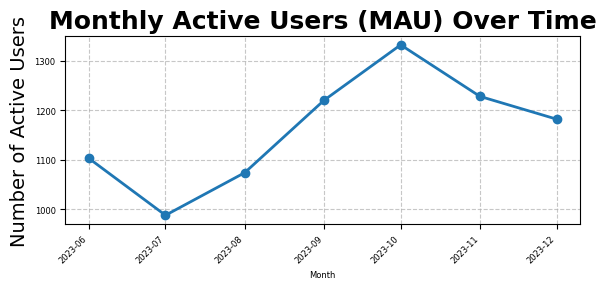

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

result1['month'] = pd.to_datetime(result1['month'])
result1 = result1.sort_values(by='month')

# Create the line chart
plt.figure(figsize=(6, 3)) # Set the figure size for better readability
plt.plot(result1['month'], result1['monthly_active_users'], marker='o', linestyle='-', color='#1f77b4', linewidth=2)

# Add title and labels
plt.title('Monthly Active Users (MAU) Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Month', fontsize=6)
plt.ylabel('Number of Active Users', fontsize=14)

# Customize grid and ticks for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=6) # Rotate x-axis labels for readability
plt.yticks(fontsize=6)

# Improve layout to prevent labels from overlapping
plt.tight_layout()

# Save the plot to a file
plt.savefig('monthly_active_users_line_chart.png')

### - Gamesession Submission Volume (Monthly)

we'll count gamesessions that have resulted in at least one clip. 

In [10]:
query2 = '''
SELECT
    DATE_TRUNC('month', gs.submited_date) AS submission_month,
    COUNT(DISTINCT gs.id) AS gamesession_submitted_with_clips
FROM
    'gamesession.csv' AS gs
JOIN
    'clips.csv' AS c ON gs.id = c.gamesession_Id
WHERE
    gs.submited_date IS NOT NULL
GROUP BY
    submission_month
ORDER BY
    submission_month;
'''
result2 = con.execute(query2).df()
display(result2)

,submission_month,gamesession_submitted_with_clips
0,2023-06-01,6021
1,2023-07-01,5474
2,2023-08-01,5324
3,2023-09-01,6111
4,2023-10-01,5794
5,2023-11-01,4778
6,2023-12-01,3066


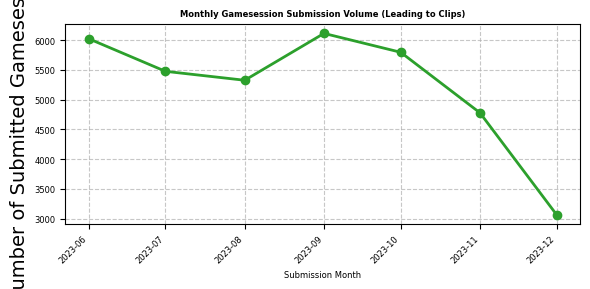

In [11]:
result2['submission_month'] = pd.to_datetime(result2['submission_month'])
result2 = result2.sort_values(by='submission_month')

# Create the line chart for Gamesession Submission Volume
plt.figure(figsize=(6, 3))
plt.plot(result2['submission_month'], result2['gamesession_submitted_with_clips'],
         marker='o', linestyle='-', color='#2ca02c', linewidth=2)

# Add title and labels
plt.title('Monthly Gamesession Submission Volume (Leading to Clips)', fontsize=6, fontweight='bold')
plt.xlabel('Submission Month', fontsize=6)
plt.ylabel('Number of Submitted Gamesessions', fontsize=14)

# Customize grid and ticks for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=6) # Rotate x-axis labels for readability
plt.yticks(fontsize=6)

# Improve layout to prevent labels from overlapping
plt.tight_layout()

# Save the plot to a file
plt.savefig('gamesession_submission_volume_line_chart.png')

## 2. Content & Product Performance:

### - Clip Download Rate: 

Indicates the value users find in the generated clips (are they downloading them?).

In [16]:
query3 = '''
WITH MonthlyGeneratedClips AS (
    SELECT
        DATE_TRUNC('month', created_at) AS month,
        COUNT(DISTINCT id) AS generated_clips_count
    FROM
        'clips.csv'
    WHERE
        created_at IS NOT NULL
    GROUP BY
        1
),
MonthlyDownloadedClips AS (
    SELECT
        DATE_TRUNC('month', created_at) AS month,
        COUNT(DISTINCT clip_id) AS downloaded_clips_count
    FROM
        'downloaded_clips.csv'
    WHERE
        created_at IS NOT NULL
    GROUP BY
        1
)
SELECT
    mgc.month,
    mgc.generated_clips_count,
    mdc.downloaded_clips_count,
    CASE
        WHEN mgc.generated_clips_count > 0 THEN ROUND(CAST(mdc.downloaded_clips_count AS REAL) * 100.0 / mgc.generated_clips_count, 3)
        ELSE 0 -- Handle cases where no clips were generated to avoid division by zero
    END AS clip_download_rate_percentage
FROM
    MonthlyGeneratedClips AS mgc
JOIN
    MonthlyDownloadedClips AS mdc ON mgc.month = mdc.month
ORDER BY
    mgc.month;
'''
result3 = con.execute(query3).df()
display(result3)

,month,generated_clips_count,downloaded_clips_count,clip_download_rate_percentage
0,2023-06-01,81789,1462,1.788
1,2023-07-01,77776,1541,1.981
2,2023-08-01,80231,1378,1.718
3,2023-09-01,87737,1812,2.065
4,2023-10-01,88862,2573,2.896
5,2023-11-01,82608,2487,3.011
6,2023-12-01,53028,1682,3.172


In [18]:
query4 = '''
WITH AllTimeGeneratedClips AS (
    SELECT
        COUNT(DISTINCT id) AS generated_clips_count
    FROM
        'clips.csv'
    WHERE
        created_at IS NOT NULL
),
AllTimeDownloadedClips AS (
    SELECT
        COUNT(DISTINCT clip_id) AS downloaded_clips_count
    FROM
        'downloaded_clips.csv'
    WHERE
        created_at IS NOT NULL
)
SELECT
    CASE
        WHEN agc.generated_clips_count > 0 THEN ROUND(CAST(adc.downloaded_clips_count AS REAL) * 100.0 / agc.generated_clips_count, 3)
        ELSE 0.0
    END AS all_time_clip_download_rate_percentage
FROM
    AllTimeGeneratedClips AS agc,
    AllTimeDownloadedClips AS adc;
'''
result4 = con.execute(query4).df()
display(result4)

,all_time_clip_download_rate_percentage
0,2.343


### - Total Shared Clips (Monthly)

Measures how much content is being distributed by users, reflecting virality and user satisfaction.

To ensures we are counting shares of clips that exist within our clips database, we will join the shared_clips table with the clips table.

In [5]:
query5 = '''
SELECT
    DATE_TRUNC('month', sc.created_at) AS shared_month,
    COUNT(DISTINCT sc.clip_id) AS total_shared_clips
FROM
    'shared_clips.csv' AS sc
JOIN
    'clips.csv' AS c ON sc.clip_id = c.id
WHERE
    sc.created_at IS NOT NULL
GROUP BY
    shared_month
ORDER BY
    shared_month;
'''
result5 = con.execute(query5).df()
display(result5)

,shared_month,total_shared_clips
0,2023-06-01,333
1,2023-07-01,241
2,2023-08-01,285
3,2023-09-01,373
4,2023-10-01,613
5,2023-11-01,719
6,2023-12-01,398


In [8]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

result5['shared_month'] = pd.to_datetime(result5['shared_month'])

# Sort the DataFrame by month to ensure the line chart progresses correctly
result5 = result5.sort_values(by='shared_month')

# Create the Plotly line chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=result5['shared_month'],
    y=result5['total_shared_clips'],
    mode='lines+markers',
    name='Total Shared Clips',
    line=dict(color='purple', width=2),
    marker=dict(size=8, symbol='circle', line=dict(width=1, color='DarkSlateGrey'))
))

# Update layout for title and labels
fig.update_layout(
    title={
        'text': 'Monthly Total Shared Clips Over Time',
        'x': 0.5, # Center the title
        'xanchor': 'center',
        'font': dict(size=20, color='black')
    },
    xaxis_title='Shared Month',
    yaxis_title='Number of Shared Clips',
    xaxis=dict(
        tickmode='auto',
        nticks=len(result5['shared_month']), # Adjust number of ticks based on data points
        tickangle=-45,
        showgrid=True,
        gridcolor='#e0e0e0'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='#e0e0e0'
    ),
    hovermode="x unified", # Shows hover info for all traces at the same x-position
    template="plotly_white" # Use a clean white background template
)


# 3. Monetization & Business Growth:

## - Premium User Growth (Monthly): 

Tracks the increase in paying subscribers.

In [12]:
query6 = '''
SELECT
    DATE_TRUNC('month', p.starts_at) AS premium_start_month,
    COUNT(DISTINCT p.user_id) AS new_premium_users
FROM
    'premium.csv' AS p
JOIN
    'gamesession.csv' AS gs ON p.user_id = gs.user_id
WHERE
    p.starts_at IS NOT NULL
GROUP BY
    premium_start_month
ORDER BY
    premium_start_month;
'''
result6 = con.execute(query6).df()
display(result6)

,premium_start_month,new_premium_users
0,2023-01-01,9
1,2023-02-01,13
2,2023-03-01,22
3,2023-04-01,27
4,2023-05-01,26
5,2023-06-01,28
6,2023-07-01,30
7,2023-08-01,32
8,2023-09-01,40
9,2023-10-01,56


In [13]:
result6['premium_start_month'] = pd.to_datetime(result6['premium_start_month'])

# Sort the DataFrame by month to ensure the line chart progresses correctly
result6 = result6.sort_values(by='premium_start_month')

# Create the Plotly line chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=result6['premium_start_month'],
    y=result6['new_premium_users'],
    mode='lines+markers',
    name='New Premium Users',
    line=dict(color='green', width=2),
    marker=dict(size=8, symbol='circle', line=dict(width=1, color='DarkSlateGrey'))
))

# Update layout for title and labels
fig.update_layout(
    title={
        'text': 'Monthly New Premium User Growth',
        'x': 0.5, # Center the title
        'xanchor': 'center',
        'font': dict(size=20, color='black')
    },
    xaxis_title='Premium Start Month',
    yaxis_title='Number of New Premium Users',
    xaxis=dict(
        tickmode='auto',
        nticks=len(result6['premium_start_month']), # Adjust number of ticks based on data points
        tickangle=-45,
        showgrid=True,
        gridcolor='#e0e0e0'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='#e0e0e0'
    ),
    hovermode="x unified", # Shows hover info for all traces at the same x-position
    template="plotly_white" # Use a clean white background template
)


## - Premium User Churn

to represent the point at which a user's premium service effectively ends due to either cancellation or natural expiration, and they are no longer contributing revenue for that plan period. those whose premium plan's ends_at timestamp falls within that month. 

In [26]:
query7 = '''
WITH MonthlyExpiringSubscriptions AS (
    -- Count unique users whose premium subscription ENDS in each month
    SELECT
        DATE_TRUNC('month', ends_at) AS month,
        COUNT(DISTINCT user_id) AS expiring_users_count
    FROM
        'premium.csv'
    WHERE
        ends_at IS NOT NULL
    GROUP BY
        1
),
MonthlyStartingActivePremium AS (
    -- Identify unique premium users who were active at the START of each month
    SELECT
        DATE_TRUNC('month', calendar.month_start_date) AS month,
        COUNT(DISTINCT p.user_id) AS active_users_at_month_start
    FROM
        (
            -- UNNEST the generated series to get individual rows of month start dates
            SELECT UNNEST(
                GENERATE_SERIES(
                    DATE_TRUNC('month', MIN(starts_at)),
                    DATE_TRUNC('month', MAX(COALESCE(ends_at, canceled_at, CURRENT_DATE))),
                    INTERVAL '1 month'
                )
            ) AS month_start_date
            FROM 'premium.csv'
        ) AS calendar
    JOIN
        'premium.csv' AS p
        ON p.starts_at < calendar.month_start_date + INTERVAL '1 month' -- Started before or during the month
        AND (
               p.ends_at IS NULL OR p.ends_at >= calendar.month_start_date -- Ends after or during the month start (still active)
            OR p.canceled_at IS NULL OR p.canceled_at >= calendar.month_start_date -- Canceled after or during the month start (still active if paid)
        )
    GROUP BY
        1
)
SELECT
    msap.month AS churn_month,
    COALESCE(mes.expiring_users_count, 0) AS churned_users_by_expiration,
    COALESCE(msap.active_users_at_month_start, 0) AS starting_active_subscribers,
    CASE
        WHEN COALESCE(msap.active_users_at_month_start, 0) > 0
        THEN ROUND(CAST(COALESCE(mes.expiring_users_count, 0) AS REAL) * 100.0 / msap.active_users_at_month_start, 3)
        ELSE 0.0
    END AS premium_churn_rate_percentage
FROM
    MonthlyStartingActivePremium AS msap
LEFT JOIN
    MonthlyExpiringSubscriptions AS mes ON msap.month = mes.month
ORDER BY
    churn_month;

'''
result7 = con.execute(query7).df()
display(result7)

,churn_month,churned_users_by_expiration,starting_active_subscribers,premium_churn_rate_percentage
0,2023-01-01,0,10,0.000000
1,2023-02-01,4,23,17.391001
2,2023-03-01,4,43,9.302000
3,2023-04-01,10,67,14.925000
4,2023-05-01,12,89,13.483000
5,2023-06-01,22,112,19.643000
6,2023-07-01,11,129,8.527000
7,2023-08-01,23,155,14.839000
8,2023-09-01,22,183,12.022000
9,2023-10-01,20,235,8.511000
